In [ ]:
# ==========================
# 🔗 Mount Google Drive & Navigasi ke Folder Proyek
# ==========================
from google.colab import drive
import shutil
import time
import os  # Untuk navigasi dan pengelolaan path
import joblib

# ==========================
# ⚙️ Konfigurasi Umum
# ==========================
import numpy as np
import pandas as pd
import random
import warnings
from collections import Counter, defaultdict  # Untuk menghitung frekuensi item dan menyimpan hasil hitungan per resolusi
from datetime import datetime
import csv

# ==========================
# 🖼️ Image Loading & Manipulation
# ==========================
from PIL import Image  # Untuk membuka dan manipulasi gambar
from skimage import io, img_as_ubyte, util, exposure
from skimage.transform import resize, rotate, AffineTransform, warp
import cv2  # OpenCV untuk manipulasi gambar lanjutan

# ==========================
# 📊 Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Untuk progress bar saat proses looping banyak gambar

# ==========================
# 🧪 Data Preparation Tools
# ==========================
# from sklearn.model_selection import train_test_split

# ==========================
# 🧪 Data Augmentation (PyTorch)
# ==========================
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# ==========================
# 🤖 Deep Learning Framework: TensorFlow & Keras
# ==========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Untuk augmentasi saat training
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2

# ==========================
# 🧮 Model Evaluation & Metrics
# ==========================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Konfigurasi warning & seed
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

seed = 0
np.random.seed(seed)
random.seed(seed)

# Set seed TensorFlow (diletakkan setelah import tf)
tf.random.set_seed(seed)

# ==========================
# 📦 Library Tambahan
# ==========================
import kagglehub

In [ ]:
%%time

drive.flush_and_unmount()

CPU times: user 8.43 ms, sys: 1.81 ms, total: 10.2 ms
Wall time: 1.27 s


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path tujuan proyek di Google Drive
target_path = '/content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label'

# Cek apakah path ada, lalu berpindah ke direktori tersebut
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"✅ Berhasil berpindah ke direktori: {os.getcwd()}")
else:
    print(f"❌ Path tidak ditemukan: {target_path}. Periksa kembali lokasi foldernya.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Berhasil berpindah ke direktori: /content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label


In [ ]:
# Path dasar
TRAIN_DIR = "/content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/dataset_split/train"
TEST_DIR = "/content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/dataset_split/test"

In [ ]:
img_size = (150, 150)
batch_size = 32

# Data augmentation + normalization untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # rotasi acak hingga 20 derajat
    width_shift_range=0.1,     # geser horizontal max 10%
    height_shift_range=0.1,    # geser vertikal max 10%
    shear_range=0.1,           # distorsi miring
    zoom_range=0.1,            # zoom in/out 10%
    horizontal_flip=True,      # flip horizontal acak
    fill_mode='nearest',       # mengisi pixel kosong setelah augmentasi
    # validation_split=0.1
)

# Hanya normalisasi untuk test
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',   # 90% dari train/ untuk training
    shuffle=True
)

# validation_generator = train_datagen.flow_from_directory(
#     TRAIN_DIR,
#     target_size=img_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation',  # 10% dari train/ untuk validasi
#     shuffle=False
# )

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 932 images belonging to 3 classes.
Found 234 images belonging to 3 classes.


In [ ]:
# val_labels = validation_generator.classes
# val_class_indices = validation_generator.class_indices

# # Invers mapping class index ke nama label
# inv_map = {v: k for k, v in val_class_indices.items()}

# # Hitung jumlah masing-masing kelas
# label_counts = Counter(val_labels)

# print("\n📊 Jumlah gambar per kelas (Validation):")
# # Tampilkan hasilnya dalam bentuk nama label
# for class_idx, count in label_counts.items():
#     print(f"{inv_map[class_idx]}: {count}")

In [ ]:
class_indices = train_generator.class_indices
print(class_indices)

{'Anorganik': 0, 'B3': 1, 'Organik': 2}


In [ ]:
class_indices = test_generator.class_indices
print(class_indices)

{'Anorganik': 0, 'B3': 1, 'Organik': 2}


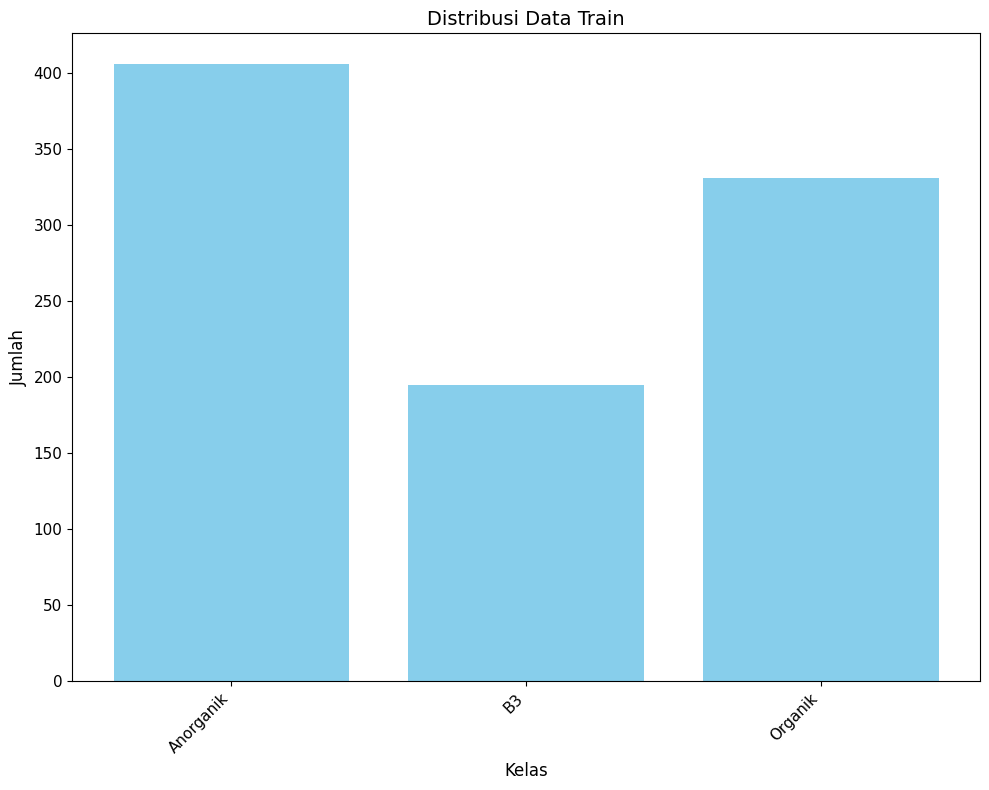

In [ ]:
def plot_train_distribution(generator, data):
    labels = list(generator.class_indices.keys())
    counts = np.bincount(generator.classes)

    # Cek apakah panjang counts dan labels sama
    if len(counts) != len(labels):
        print(f"⚠️ Jumlah kelas terdeteksi: {len(labels)}, tapi hanya {len(counts)} kelas yang memiliki data.")
        # Kurangi label yang tidak punya data
        labels = labels[:len(counts)]

    plt.figure(figsize=(10, 8))
    plt.bar(labels, counts, color='skyblue')
    plt.title(f"Distribusi Data {data}", fontsize=14)
    plt.xlabel("Kelas", fontsize=12)
    plt.ylabel("Jumlah", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()


# Panggil fungsi
plot_train_distribution(train_generator, "Train")

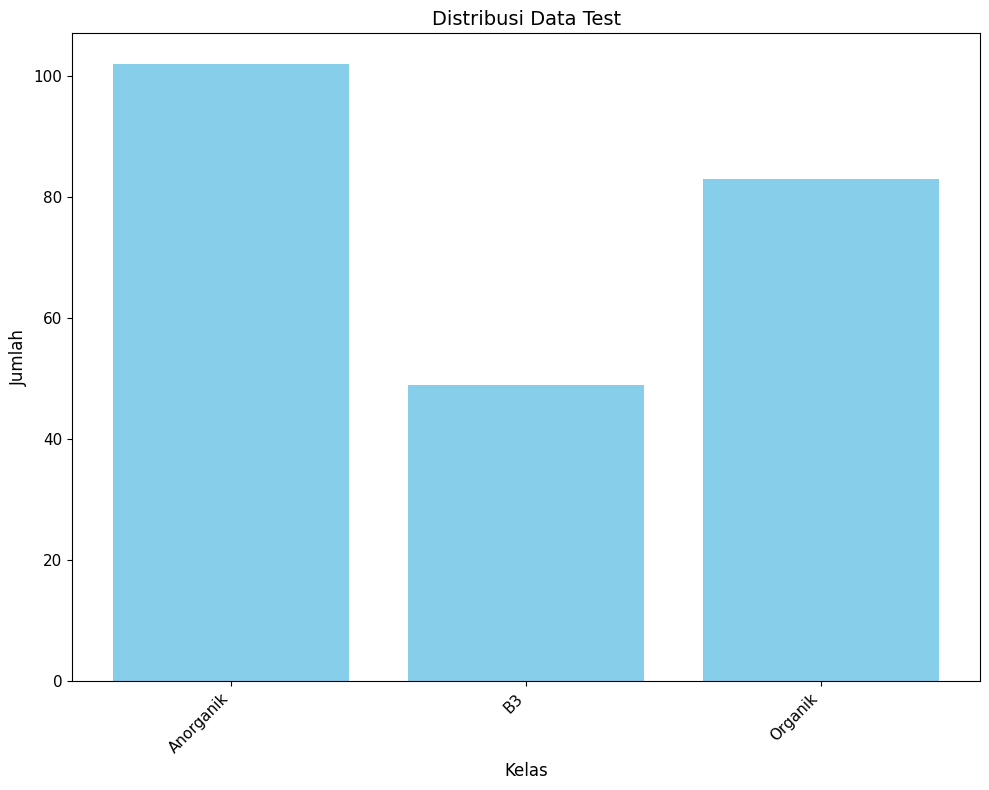

In [ ]:
plot_train_distribution(test_generator, "Test")

In [ ]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150,150,3))

for layer in pre_trained_model.layers:
    layer.trainable = False

####################### Init sequential model ##################################
model = Sequential()
model.add(pre_trained_model)

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# 2st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
# model.add(Flatten(name="flatten"))
model.add(GlobalAveragePooling2D()),
# 1nd Dense Layer
model.add(Dropout(0.5))
# 1nd Dropout Layer
model.add(Dense(128, activation="relu"))
# Final Dense layer => For output prediction
model.add(Dense(3, activation='softmax'))

<ipython-input-51-a6ea80273a23>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150,150,3))


In [ ]:
# Compile model
optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,653,859 (10.12 MB)

 Trainable params: 395,875 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('model_h5.keras', monitor='loss', save_best_only=True, mode='min')
# early_stopping = EarlyStopping(monitor='accuracy',
#                                patience=5,
#                                min_delta=0.001,
#                                restore_best_weights=True,
#                                mode='max',
#                                baseline=0.96)
reduce_lr = ReduceLROnPlateau(monitor='loss',        # pantau loss training
                              factor=0.5,            # turunkan lr sebesar 50%
                              patience=2,            # jika loss tidak membaik selama 2 epoch
                              min_lr=1e-6,           # minimal learning rate
                              verbose=1)

In [ ]:
%%time

# Melatih model
num_epochs = 10

history = model.fit(train_generator,
                    epochs=num_epochs,
                    # validation_data=validation_generator,
                    callbacks=[checkpoint, reduce_lr],
                    verbose=1)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.5827 - loss: 1.0069 - learning_rate: 0.0010
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6799 - loss: 0.6514 - learning_rate: 0.0010
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7537 - loss: 0.5139 - learning_rate: 0.0010
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8288 - loss: 0.3870 - learning_rate: 0.0010
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8760 - loss: 0.3243 - learning_rate: 0.0010
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8578 - loss: 0.3494 - learning_rate: 0.0010
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8739 - loss: 0.3169 - learning_rate: 0.0010
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8813 - loss: 0.3448 - learning_rate: 0.0010
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8983 - loss: 0.2914 - learning_rate: 0.0010
Epoch 10/10
30/30 ━━━━━━━━━━

In [ ]:
# Evaluasi model menggunakan data pengujian
evaluation = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

# Menampilkan hasil evaluasi
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")

234/234 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8752 - loss: 0.3125
Test Loss: 0.4064
Test Accuracy: 0.8632


In [ ]:
# Reset generator
test_generator.reset()

preds_1 = model.predict(test_generator)             # Menggunakan model untuk memprediksi pada data test
pred_labels = np.argmax(preds_1, axis=1)            # Mengambil label prediksi (menggunakan argmax untuk multi-class)
y_true = test_generator.classes                     # Label sebenarnya

# Evaluasi Utama
accuracy = accuracy_score(y_true, pred_labels)
precision = precision_score(y_true, pred_labels, average='weighted')
recall = recall_score(y_true, pred_labels, average='weighted')
f1 = f1_score(y_true, pred_labels, average='weighted')

print("🛑 EVALUASI MODEL")
print("=" * 54)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}\n")

print("🛑 CLASSIFICATION REPORT")
print("=" * 54)
print(classification_report(y_true, pred_labels, target_names=test_generator.class_indices.keys(), digits=4))

234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step
🛑 EVALUASI MODEL
Accuracy: 0.86
Precision: 0.87
Recall: 0.86
F1 Score: 0.86

🛑 CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Anorganik     0.8182    0.8824    0.8491       102
          B3     0.7826    0.7347    0.7579        49
     Organik     0.9744    0.9157    0.9441        83

    accuracy                         0.8632       234
   macro avg     0.8584    0.8442    0.8504       234
weighted avg     0.8661    0.8632    0.8637       234



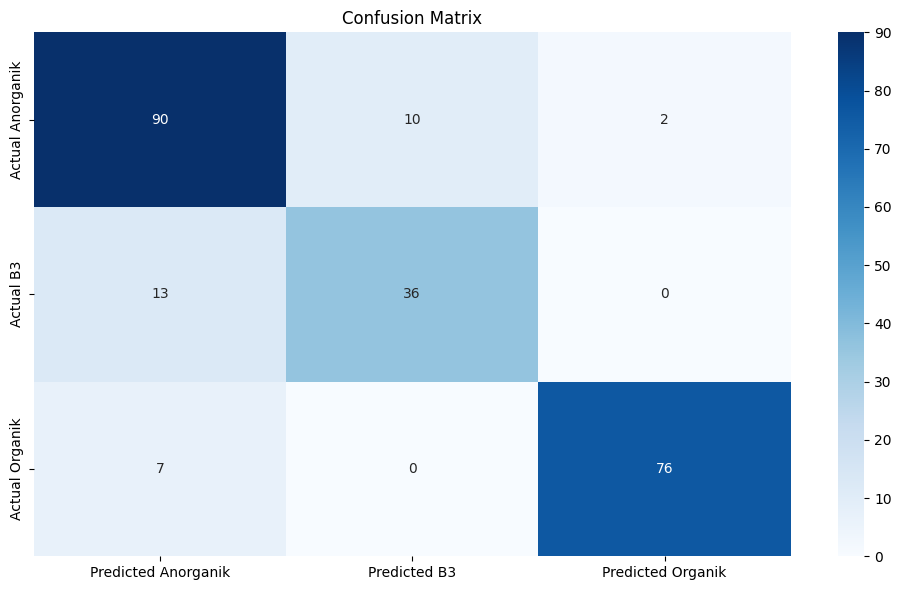

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, pred_labels)
label_names = list(test_generator.class_indices.keys())
df_cm = pd.DataFrame(cm, index=[f"Actual {x}" for x in label_names],
                         columns=[f"Predicted {x}" for x in label_names])
plt.figure(figsize=(10,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

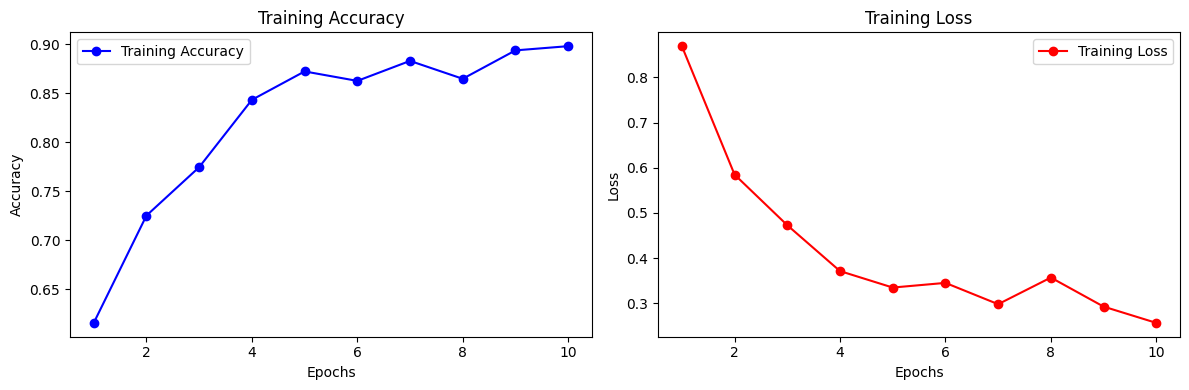

In [ ]:
def plot_training_history(history):
    acc = history.history.get('accuracy', [])
    loss = history.history.get('loss', [])
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Plot Training Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# # Load dari file .keras
# model = keras.models.load_model("model_h5.keras")

# Simpan ulang ke format .h5
model.save("model.h5")

In [ ]:
joblib.dump(model, 'model.pkl')

['model.pkl']

In [ ]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [ ]:
!pip install tensorflowjs

!tensorflowjs_converter \
  --input_format=keras \
  "/content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/model.h5" \
  "/content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/tfjs_model"

2025-05-27 04:41:32.368957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748320892.547202   34077 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748320892.564370   34077 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
# Load the Keras model
model_TFLITE = tf.keras.models.load_model('model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model_TFLITE)
tflite_model = converter.convert()

# Buat folder 'tflite' kalau belum ada
os.makedirs("tflite", exist_ok=True)

# Save the converted model to a file
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp8nrge8sp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140338327862736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338327851984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338013081808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338327851408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338327861200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338013092368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338013091984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338013091600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338013091792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338013093136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1403380130904

In [ ]:
labels = train_generator.class_indices

# Urutkan berdasarkan index
ordered_labels = sorted(labels.items(), key=lambda x: x[1])
with open('tflite/labels.txt', 'w') as f:
    for label, _ in ordered_labels:
        f.write(label + '\n')

In [ ]:
# contoh konversi model Keras ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # model dilatih 3 kelas
tflite_model = converter.convert()

# Simpan ke file
with open("model_3kelas.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpd865c4gy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_2195')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140338179747728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338179750800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338179751184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338179750992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338179748112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338179749648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338179750032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338179746000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338179748880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338179751760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140338179

In [ ]:
!pip freeze > requirements.txt

In [ ]:
print("Labels:")
for i, label in enumerate(labels):
    print(f"{i}: {label}")
print("Jumlah label:", len(labels))


Labels:
0: Anorganik
1: B3
2: Organik
Jumlah label: 3


1) Pred: Anorganik (98.71%) | True: Anorganik | Logits → Anorganik: 0.99, B3: 0.01, Organik: 0.00
2) Pred: B3 (99.53%) | True: B3 | Logits → Anorganik: 0.00, B3: 1.00, Organik: 0.00
3) Pred: Organik (94.48%) | True: Organik | Logits → Anorganik: 0.05, B3: 0.00, Organik: 0.94




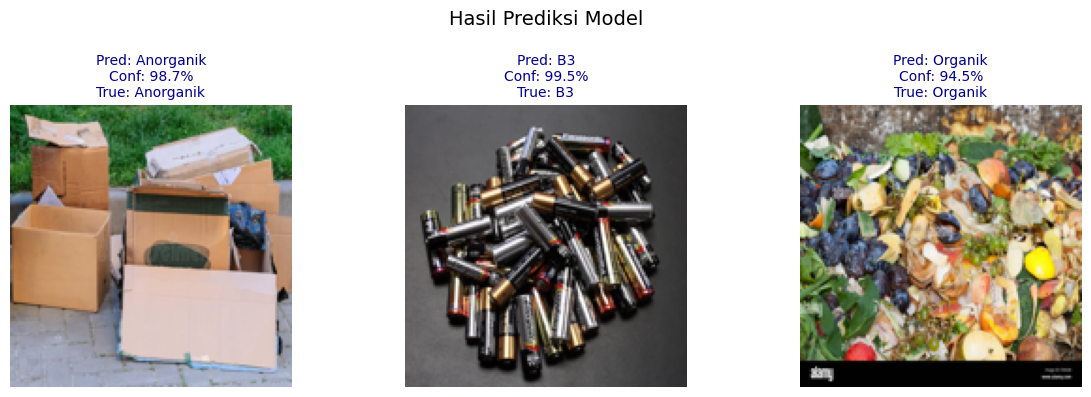

In [ ]:
# Buat timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Path
image_dir = "/content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/dataset_split/test"
tflite_model_path = "/content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/model_3kelas.tflite"
label_file_path = "/content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/tflite/labels.txt"
log_dir = "/content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/logs"
os.makedirs(log_dir, exist_ok=True)

# File log & plot dengan timestamp
txt_log_path = os.path.join(log_dir, f"pred_log_{timestamp}.txt")
csv_log_path = os.path.join(log_dir, f"pred_log_{timestamp}.csv")
plot_path = os.path.join(log_dir, f"pred_plot_{timestamp}.png")

# Ambil label
with open(label_file_path, "r") as f:
    target_labels = [line.strip() for line in f.readlines()]

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
height, width = input_shape[1], input_shape[2]
input_dtype = input_details[0]['dtype']

# Preprocess image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((width, height))
    img_array = np.array(img).astype(np.float32) / 255.0
    if input_dtype == np.uint8:
        img_array = (img_array * 255).astype(np.uint8)
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

# Ambil 1 gambar dari setiap label
image_extensions = ['.jpg', '.jpeg', '.png']
image_paths, true_labels = [], []

for label in target_labels:
    label_path = os.path.join(image_dir, label)
    if os.path.isdir(label_path):
        files = [f for f in os.listdir(label_path) if any(f.lower().endswith(ext) for ext in image_extensions)]
        if files:
            selected_file = random.choice(files)  # pilih satu file secara acak
            image_paths.append(os.path.join(label_path, selected_file))
            true_labels.append(label)

# Logging
txt_lines = []
csv_lines = [["Image", "True Label", "Predicted Label", "Confidence (Logit)"] + target_labels]

# Visualisasi
num_images = len(image_paths)
cols = min(num_images, 4)
rows = int(np.ceil(num_images / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten() if num_images > 1 else [axes]

for idx, image_path in enumerate(image_paths):
    img, input_tensor = preprocess_image(image_path)

    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]

    predicted_index = np.argmax(output_data)
    predicted_label = target_labels[predicted_index]
    confidence = output_data[predicted_index] * 100
    logit_summary = ", ".join([f"{label}: {logit:.2f}" for label, logit in zip(target_labels, output_data)])

    # Print & log
    log_line = f"{idx+1}) Pred: {predicted_label} ({confidence:.4f}%) | True: {true_labels[idx]} | Logits → {logit_summary}"
    print(log_line)
    txt_lines.append(log_line)
    csv_lines.append([os.path.basename(image_path), true_labels[idx], predicted_label, f"{confidence:.2f}"] +
                     [f"{logit:.2f}" for logit in output_data])

    # Plot gambar
    axes[idx].imshow(img)
    axes[idx].set_title(f"Pred: {predicted_label}\nConf: {confidence:.1f}%\nTrue: {true_labels[idx]}",
                        fontsize=10, color='darkblue')
    axes[idx].axis('off')

# Kosongkan subplot yang tidak dipakai
for i in range(num_images, len(axes)):
    axes[i].axis('off')

print("\n")
plt.suptitle("Hasil Prediksi Model", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Simpan visualisasi
plt.savefig(plot_path)

# Simpan log
with open(txt_log_path, "w") as f:
    f.write("\n".join(txt_lines))

with open(csv_log_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(csv_lines)

print(f"\n✅ Log disimpan di:\n- {txt_log_path}\n- {csv_log_path}\n🖼️ Visualisasi disimpan di:\n- {plot_path}")


✅ Log disimpan di:
- /content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/logs/pred_log_20250527_055745.txt
- /content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/logs/pred_log_20250527_055745.csv
🖼️ Visualisasi disimpan di:
- /content/drive/MyDrive/Capstone_Project/Klasifikasi_Gambar_Sampah_3_Label/logs/pred_plot_20250527_055745.png


<Figure size 640x480 with 0 Axes>